# Accuracy and Visualizations

## Summary

The purpose of this notebook is to compare our results to a “Silver Standard” in order to gauge our performance. We begin with a discussion of why some divergence from the standard is desirable. After merging our predictions with those of the USPTO, we find that our performance is better in some industries than others. We perform best on textiles, paper, metal and computer and electronics. Our most costly failure is in chemicals and we point the reader to the further refinements section for our ideas on how to resolve this.

![Image](Data\Images\Workflow_2.4.png?raw=true)

## Table of Contents

* <a href='#Part1'>Comparison to Silver Standard</a>
    * <a href='#step1.0'>Step 1.0 - Discussion</a>
    * <a href='#step1.1'>Step 1.1 - Import</a>
    * <a href='#step1.2'>Step 1.2 - Merge</a>
    * <a href='#step1.3'>Step 1.3 - Analysis</a>

<a id='Part1'></a>
## Comparison to Silver Standard 

<a id='step1.0'></a>
**Step 1.0 - Discussion - Why isn't it "Gold"**
- In 2012 the USPTO mapped patents to NAICS 2002 industries by establishing a concordance between United States Patent Classes and NAICS industries.  
- We use the USPTO predictions as a baseline to gauge our performance.
- That said, it is not our goal to perfectly recreate the USPTO's predictions. The USPTO predictions provide a "silver" standard, something we wish to approach but not replicate for two reasons:

1.) As detailed in our motivations, the USPTO predictions are imperfect. The following is an excerpt from the USPTO's 2012 report (input/explan_naicsasg.htm):

    "PLEASE NOTE ! USPTO staff are not classifying U.S. patents directly into NAICS industry categories. The distribution of patent counts by NAICS industry category, as displayed in this report, is determined using a very general concordance between two substantially different classification systems, the U.S. Patent Classification System and the North American Industry Classification System. As such, the patent counts associated with each of the different NAICS categories should be viewed with caution and may serve only as a very general indicator of the patenting activity in those categories."

Establishing a concordance by eye is both prone to human error and is conceptually tenuous given that tech fields and industry classes endeavour to capture different things

2.) The USPTO's method is to construct a concordance between tech fields and industries so that each assignee is mapped to multiple industries. However, the USPTO only publicly shares two things (1) the concordance table (2) a list of the top patentees by industry. In the interests of not performing their analysis from scratch (which is non-trivial) we use (2) and categorize patents in the baseline according to the industry their assignee is most active in. In other words each assignee is attributed only one NAICS.

This is problematic whenever a firm innovates in multiple product spaces. e.g. Hitachi Ltd has a metals and a chemicals arm and this approach for constructing the baseline demands we select only one. 

NAICS predictions by Chronan allow each assignee to have multiple NAICS so that the more an assignee patents in multiple industries the more heavily Chronan predictions will diverge from the baseline.

<a id='step1.1'></a>
**Step 1.1 - Construct Silver Standard**

Constructing the Silver Standard requires 3 inputs:
1. **NBER patent data project** - furnishes us with a list of patents up to 2004 with unclean assignee formatted in a specific way
2. **Bronwyn Hall name-matching project** - which maps unclean assignees to standardized assignee names 
3. **The USPTO estimates of the top patentees by industry** - provides a standardized assignee -> naics2002 mapping

The approach below is to import and format each of the inputs and then chain them together to yield a mapping of patents to naics2002 baseline where naics2002 is the industry the assignee is most active in.

In [2]:
! pip install pyquery

In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import pandas as pd
import time
import string
import re
import collections
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import json
from pylab import rcParams

**Import the USPTO estimates of the top patentees by industry**

In [3]:
%%time
# import uspto estimates of patent activity by company and industry
supertable = []
sequence_nos = ["0"+str(i) if i<10 else str(i) for i in range(1,31)]
for seq in sequence_nos:
    filename = 'data/USPTO Baseline' + seq + 'naics_asg_fg.htm'
    soup = BeautifulSoup(open(filename), "html.parser")
    #time.sleep(1)
    
    table_rows = soup.findAll("tr")

    naics = []
    naics_desp = []
    comn = []
    patent_count = [] 
    for row in table_rows:
        try:
            naics.append(row.findAll("td")[2].get_text().strip())
            naics_desp.append(row.findAll("td")[3].get_text().strip())
            comn.append(row.findAll("td")[4].get_text().strip())
            patent_count.append(int(row.findAll("td")[49].get_text()))
        except:
            pass
    supertable.append(zip(naics,naics_desp,comn,patent_count)) 
supertable_flat = [i for row in supertable for i in row]
supertable_df = pd.DataFrame(supertable_flat, columns=["naics","naics_desc","assname","patent_count"])

# subset naics
naics_to_drop = ['3251','3252','3254','3253,3255,3256,3259','3341','3342','3344','3345','3343,3346','3361-3363','3364','3365,3366,3369','3391','339 (except 3391)']
supertable_df = supertable_df[supertable_df['naics'].map(lambda naics: naics not in naics_to_drop)]


Wall time: 1min 38s


**Import the Bronwyn Hall name-matching project and merge with USPTO**

In [4]:
# import standardized assignee names and their uspto id numbers
coname04_df = pd.read_csv('data/USPTO Baseline/coname04_std.csv')
coname04_df['assname'] = [i.strip() for i in coname04_df['assname'].values]

# merge on standardized assignee name to yield uspto id number
supertable_merged_df = pd.merge(supertable_df, coname04_df, on='assname')

# reduce from company-naics level to company-level
supertable_merged_df = supertable_merged_df.sort(columns=['assname','patent_count'], ascending=[1,0])
grouped = supertable_merged_df.groupby("assname")
supertable_firstindonly_df = grouped.first()
supertable_firstindonly_df["base"] = grouped["patent_count"].sum()
supertable_firstindonly_df = supertable_firstindonly_df.reset_index()

# formatting
supertable_firstindonly_df = supertable_firstindonly_df.rename(columns={'assignee':'uspto_assignee','patent_count':'patents_in_major_ind','base':'patents_all_inds'})
supertable_firstindonly_df = supertable_firstindonly_df.drop(['pat6704','file','list','asstype','standard_name','stem_name','same'], 1)
supertable_firstindonly_df.head()


,assname,naics,naics_desc,patents_in_major_ind,uspto_assignee,patents_all_inds
0,"2WIRE, INC.",334,"Computer and Electronic Products ( ** ROLLUP, ...",51,778199,51
1,"3-DIMENSIONAL PHARMACEUTICALS, INC.",325,"Chemicals ( ** ROLLUP, includes 3251-3259 ** )",63,715707,63
2,3COM CORPORATION,334,"Computer and Electronic Products ( ** ROLLUP, ...",1293,641805,1407
3,3COM TECHNOLOGIES,334,"Computer and Electronic Products ( ** ROLLUP, ...",41,761278,41
4,"3D SYSTEMS, INC.",326,Plastics and Rubber Products,105,641835,195


**Import the NBER patent data project and merge with the USPTO and Name Matching Project**

In [5]:
# import patent level data
pat76_06_assg_df = pd.read_csv('data/USPTO Baseline/pat76_06_assg.csv')

# merge on uspto_assignee (an id number)
patents_ind_df = pd.merge(pat76_06_assg_df, supertable_firstindonly_df, on='uspto_assignee')
patents_ind_df.to_csv('data/USPTO Baseline/pat_ind_merge.csv')

<a id='step1.2'></a>
**Step 1.2 - Pull in Chronan predictions and merge with those of the USPTO**
- We apply a major assumption here. For each patent we choose the predicted industry by largest weight. 
- We do not apply a threshold to see if weights are significantly strong, nor do we apply a threshold on the difference between the largest weight and second largest weight to see if our majority ruling makes sense.

In [6]:
# definitions
codes = ['313-316','322,323','332','326','331','335','333','334','339','327','336','325','337','311']
descriptions = ['Textiles, Apparel and Leather','Paper, Printing and support activities','Fabricated Metal Products','Plastics and Rubber Products','Primary Metal','Electrical Equipment, Appliances, and Components','Machinery','Computer and Electronic Products','Miscellaneous Manufacturing','Nonmetallic Mineral Products','Transportation Equipment','Chemicals','Furniture and Related Products','Food']
def_dict = dict(zip(codes,descriptions))
#zip(list(patents_ind_df.naics.unique()), list(patents_ind_df.naics_desc.unique()))

# some prep for the merge
patents_ind_df['patent_id'] = "US0" + patents_ind_df['patent'].astype(str)
patents_ind_df = patents_ind_df[patents_ind_df['gyear']>1999]

In [7]:
# import json output of aws and save as pandas df
jsonurl = 'https://s3.amazonaws.com/cs109project/df11/out_02-03_t40.json'
with open(jsonurl, 'rb') as f:
    data = f.readlines()
    
data = map(lambda x: x.rstrip(), data)
data_json_str = "[" + ','.join(data) + "]"
data_df = pd.read_json(data_json_str)

In [8]:
# reshape               
rename_dict = dict(zip(data_df.columns[:21], "naics" + data_df.columns[:26]))
data_df2 = data_df.rename(columns=rename_dict)
data_df2 = pd.wide_to_long(data_df2, ['naics'], i = 'patent_id', j = 'value') 
data_df2 = data_df2.reset_index()
data_df2 = data_df2.rename(columns={'value':'naics_chronan','naics':'chronan_wgt','assignee':'chronan_assignee'})
data_df2["naics_chronan"] = data_df2["naics_chronan"].astype(str)

# get major industry
data_df3 = data_df2.sort(columns=['patent_id','chronan_wgt'],ascending=[1,0]).groupby('patent_id').first().reset_index()
data_df3.head()

,patent_id,naics_chronan,chronan_assignee,city,country,date,state,chronan_wgt
0,US06334220,322,NaN,Dallas,NaN,20020101,TX,0.152685
1,US06334221,327,McNichols Randick Oapos;Dea amp; Tooliatos LLP,Auckland,NZ,20020101,NaN,0.179930
2,US06334222,334,NaN,Danbury,NaN,20020101,CT,0.105256
3,US06334223,322,NaN,Amherst,NaN,20020101,NY,0.090086
4,US06334224,337,"Hydrabaths, Inc.",Costa Mesa,NaN,20020101,CA,0.114595


In [9]:
# merge in chronan data by merging on patent_no
# store as variable naics_chronan
patents_ind_df = pd.merge(patents_ind_df, data_df3, on='patent_id')
print patents_ind_df.shape
patents_ind_df.head()
#patents_ind_df["naics_chronan"] = np.random.choice(['311','312','313','314','315','316','321','322','323','325','326','327','331','332','333','334','335','336','337','339'], patents_ind_df.shape[0], replace=True)

(227085, 18)


,gday,gmonth,gyear,patent,uspto_assignee,assname,naics,naics_desc,patents_in_major_ind,patents_all_inds,patent_id,naics_chronan,chronan_assignee,city,country,date,state,chronan_wgt
0,16,4,2002,6373131,513770,SIGNETICS CORPORATION,334,"Computer and Electronic Products ( ** ROLLUP, ...",230,230,US06373131,331,Signetics,Menlo Park,NaN,20020416,CA,0.129631
1,28,5,2002,6395582,513770,SIGNETICS CORPORATION,334,"Computer and Electronic Products ( ** ROLLUP, ...",230,230,US06395582,331,Signetics,Inchon,NaN,20020528,CA,0.175467
2,1,1,2002,6335766,242085,HARRIS CORP.,334,"Computer and Electronic Products ( ** ROLLUP, ...",2412,2963,US06335766,311,Harris Corporation,Quincy,NaN,20020101,IL,0.159509
3,1,1,2002,6335767,242085,HARRIS CORP.,334,"Computer and Electronic Products ( ** ROLLUP, ...",2412,2963,US06335767,326,Harris Corporation,San Jose,NaN,20020101,CA,0.330722
4,22,1,2002,6341159,242085,HARRIS CORP.,334,"Computer and Electronic Products ( ** ROLLUP, ...",2412,2963,US06341159,311,Harris Corporation,Simi Valley,NaN,20020122,CA,0.140771


In [10]:
patents_ind_df.naics_chronan.unique()

array(['331', '311', '326', '333', '316', '314', '322', '332', '321',
       '339', '325', '312', '334', '336', '313', '327', '337', '335',
       '324', '315', '323'], dtype=object)

In [11]:
# harmonize 3digit naics
patents_ind_df["naics_chronan_fmt"] = patents_ind_df["naics_chronan"]
patents_ind_df["naics_chronan_fmt"] = patents_ind_df["naics_chronan_fmt"].replace('313','313-316')
patents_ind_df["naics_chronan_fmt"] = patents_ind_df["naics_chronan_fmt"].replace('314','313-316')
patents_ind_df["naics_chronan_fmt"] = patents_ind_df["naics_chronan_fmt"].replace('315','313-316')
patents_ind_df["naics_chronan_fmt"] = patents_ind_df["naics_chronan_fmt"].replace('316','313-316')
patents_ind_df["naics_chronan_fmt"] = patents_ind_df["naics_chronan_fmt"].replace('322','322,323')
patents_ind_df["naics_chronan_fmt"] = patents_ind_df["naics_chronan_fmt"].replace('323','322,323')
list(patents_ind_df.naics_chronan_fmt.unique())

['331',
 '311',
 '326',
 '333',
 '313-316',
 '322,323',
 '332',
 '321',
 '339',
 '325',
 '312',
 '334',
 '336',
 '327',
 '337',
 '335',
 '324']

<a id='step1.3'></a>
**Step 1.3 - Analyze Chronan performance**

We measure our performance using two approaches.

1. We generate a boolean (=1 if USPTO and Chronan industry prediction agree, =0 otherwise). We then plot rate of agreement by industry. If we perfectly recreate the USPTO baseline, agreement rate would equal 1 for every industry. Remember however that this would be strange given that the baseline only allows one industry per company.

2. We plot the distribution of Chronan industry predictions by USPTO industry. Suppose we are looking at the distribution of Chronan predictions for the USPTO industry 331 - Primary Metals Mfg. If we have the case of agreement approximately equals 1, then there would be a large peak at NAICS prediction Chronan = "331". 

In other words (1) helps us determine for which industries USPTO and Chronan predictions agree/differ most. We can then use (2) to observe any systemic mistakes if for instance we repeatedly classify one industry as another.

In [12]:
patents_ind_df["count"] = 1
grouped = patents_ind_df.groupby(['naics','naics_chronan_fmt'])
groupeds = grouped["count"].sum().reset_index()


overall agreement rate = 0.0576524208997


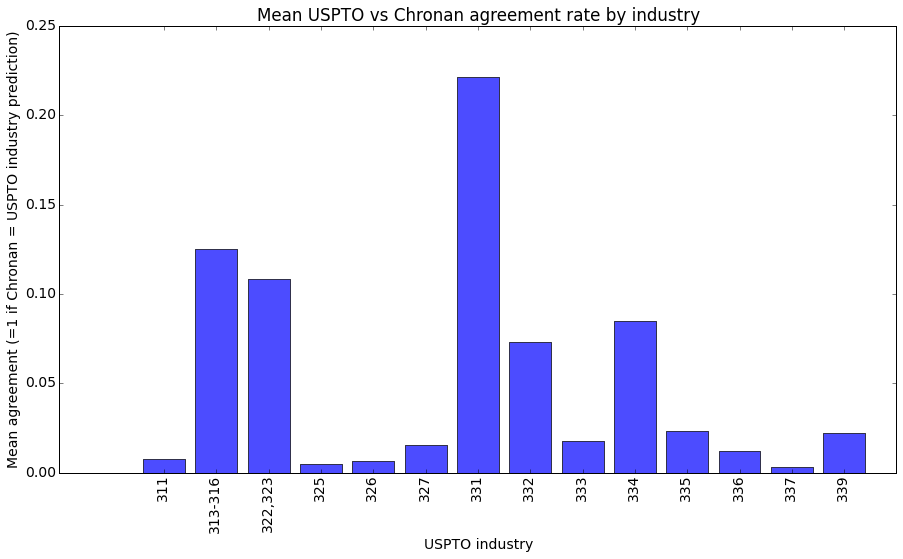

In [14]:
patents_ind_df["chronan_uspto_agree"] = patents_ind_df["naics"]==patents_ind_df["naics_chronan_fmt"]
print "overall agreement rate = " + str(patents_ind_df["chronan_uspto_agree"].mean())

rcParams['figure.figsize'] = 15, 8
plt.rcParams.update({'font.size': 14})

grouped_agree_rate = patents_ind_df.groupby("naics").mean().reset_index()
plt.bar(grouped_agree_rate.index, grouped_agree_rate.chronan_uspto_agree, align='center', color='blue', alpha=.7)
plt.xticks(grouped_agree_rate.index, grouped_agree_rate.naics, rotation=90)
plt.title("Mean USPTO vs Chronan agreement rate by industry")
plt.xlabel("USPTO industry")
plt.ylabel("Mean agreement (=1 if Chronan = USPTO industry prediction)")

- We perform better on some industries than others. In particular, text analysis seems to do a good job picking up 313-316 (Textiles, Apparel and Leather Mfg), 322,323 (Paper, Printing and support activities), 331 and 332 (Primary and Fabricated Metals Mfg) and 334 (Computer and Electronics Mfg)

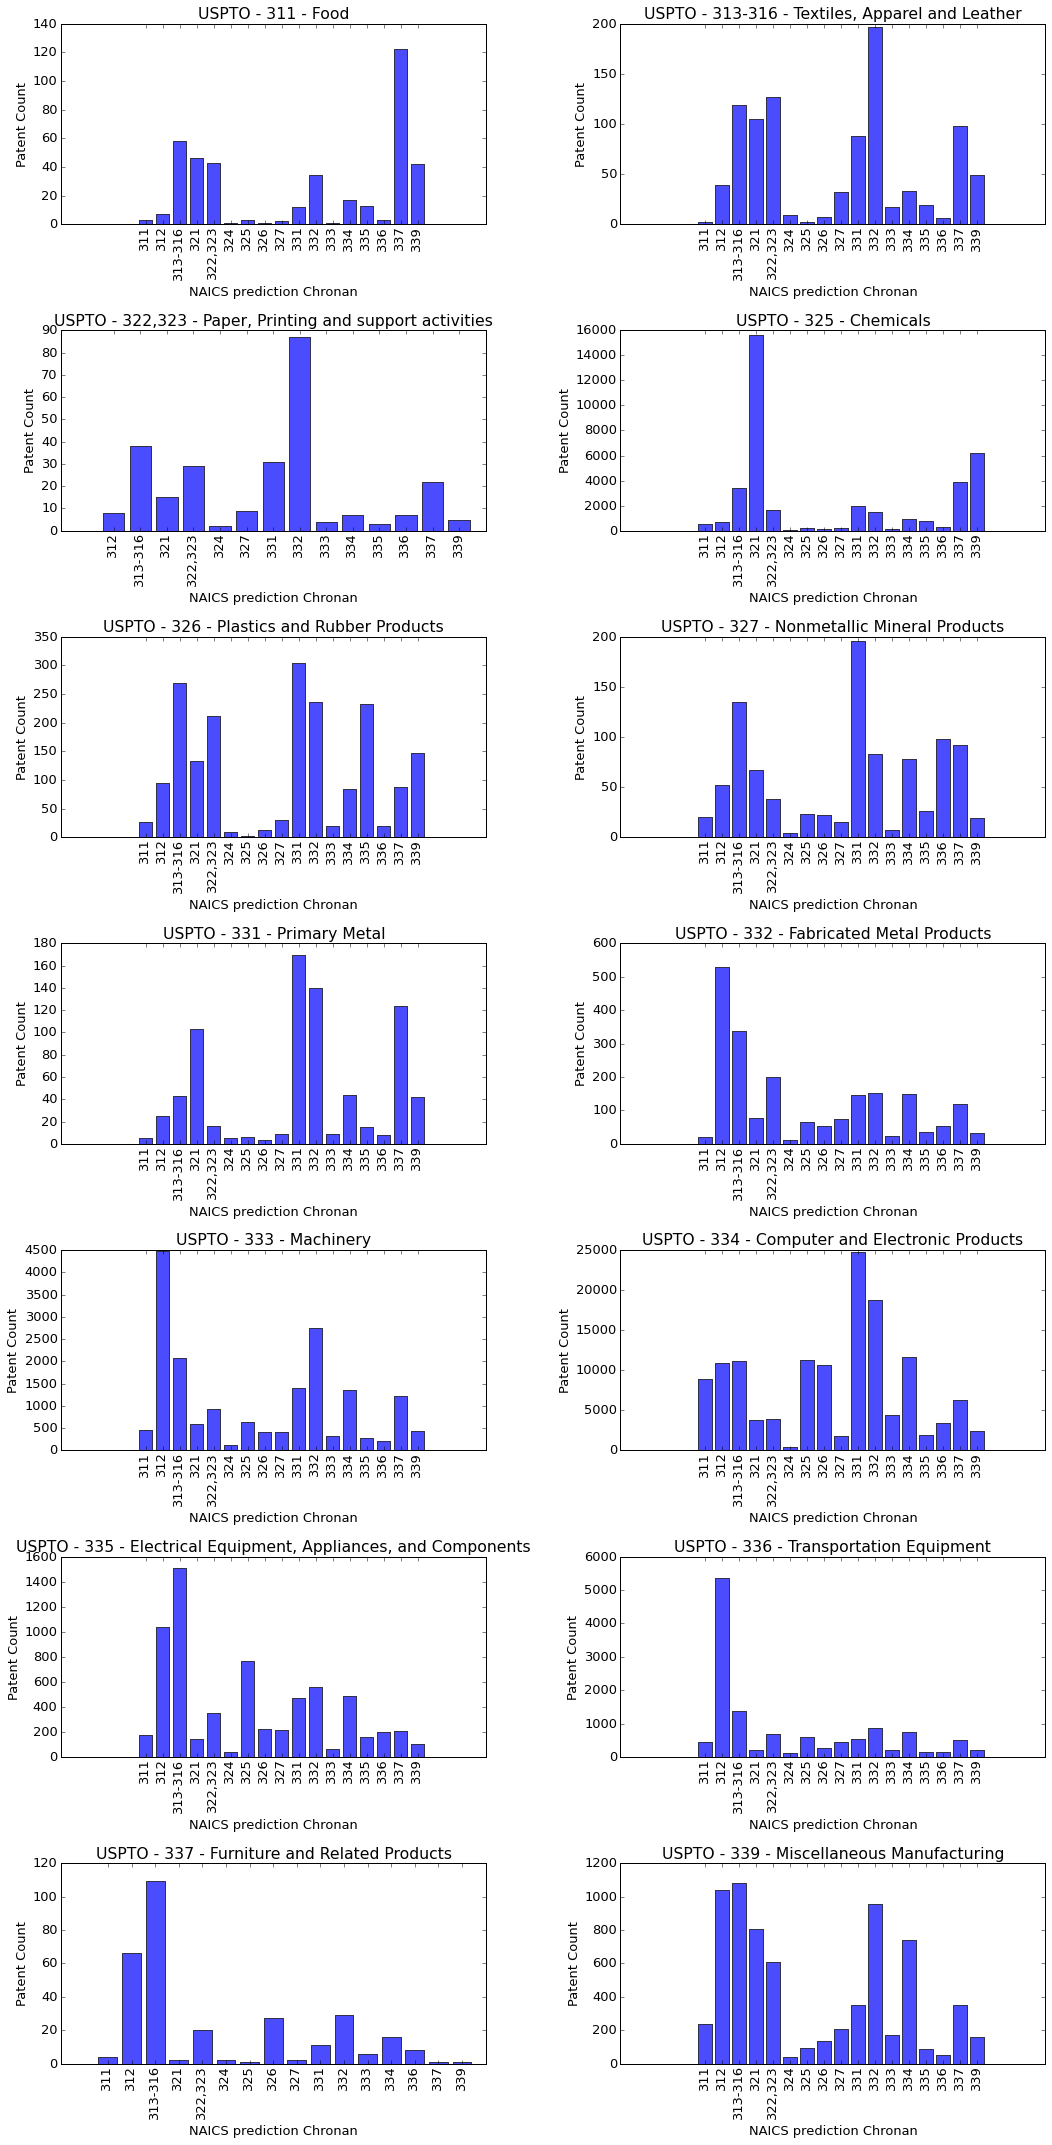

In [13]:
rcParams['figure.figsize'] = 15, 30
plt.rcParams.update({'font.size': 13})

for n, ind in enumerate(groupeds.naics.unique()):
    groupedss = groupeds[groupeds["naics"]==ind].reset_index()
    
    #print genre
    plt.subplot(7,2,n+1)
    plt.bar(groupedss.index, groupedss["count"], align='center', color='blue', alpha=.7)
    plt.xticks(groupedss.index, groupedss["naics_chronan_fmt"], rotation=90)
    plt.title("USPTO - " + ind + " - " + def_dict[ind])
    plt.xlabel("NAICS prediction Chronan")
    plt.ylabel("Patent Count")

plt.tight_layout()

- Our performance however is worse on other industries evident in the panel above.
- Consider "311 - Food" which we route to "337 - Furniture & Related Products". Peculiar! 
- Similarly patents mapped to "336 - Transportation Equipment" in the baseline, are most frequently mapped to "312 - Beverages and Tobacco" by Chronan's approach. 
- That being said Food is also one of the smaller industries whose scale is in the hundreds. 
- We do much better on "334 - Computer and Electronics" whose scale is in the tens of thousands.

In [17]:
data_df3.to_csv('out_02-03_t40.csv')